### Nome: Larissa de Oliveira Penteado
### NUsp: 8941338

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import itertools
from mac0460_5832.utils import *

In [2]:
"""Funcoes extraidas do github de Dennis José da Silva, de eps feitos para a materia Mac0470-Visao Computacional e
processamento de imagens"""

def read_image(filename):
    import PIL.Image
    return pil2array(PIL.Image.open(filename)) 

def pil2array(pil):
    w, h = pil.size
    shape = (h, w)
    image_dtype = np.uint8
    if pil.mode == '1':
        image_dtype = np.bool
    elif pil.mode == 'L':
        image_dtype = np.uint8
    elif pil.mode == 'I;16B':
        image_dtype = np.uint16
    elif pil.mode  in ('F', 'I'):
        image_dtype = np.uint32
    elif pil.mode == 'P':
        pil = pil.convert('RGB')
        shape = (h,w,3)
    elif pil.mode in ('RGB', 'YCbCr'):
        shape = (h,w,3)
        image_dtype = np.uint8
    elif pil.mode in ('RGBA', 'CMYK'):
        shape = (h,w,4)
        image_dtype = np.uint8
    else:
        raise TypeError("Invalid or unimplemented PIL image mode '%s'" % pil.mode)
    img = np.array(pil.getdata(), image_dtype).reshape(shape)
    if img.dtype == bool:
        return img
    return img > 127

def display_image(ima, width=None, height=None):
    from io import BytesIO
    import PIL.Image
    from IPython.display import display, Image

    im = PIL.Image.fromarray(np.uint8(ima))
    bio = BytesIO()
    im.save(bio, format='png')

    if width is None and height is None:
        display(Image(bio.getvalue(),  format='png'))
    elif width is None:
        display(Image(bio.getvalue(), height=height,  format='png'))
    elif height is None:
        display(Image(bio.getvalue(), width=width,  format='png'))
    else:
        display(Image(bio.getvalue(), width=width, height=height,  format='png'))

In [3]:
def insert_counter(key, counter, value):
    if not key in counter:
            counter[key] = [0, 0]
    counter[key][value] += 1
    
def check_counter(key, counter):
    if key in counter:
        return counter[key]
    else: return False

def get_value(i, j, img):
    H, W = np.shape(img)
    if i<0 or j<0 or i>=H or j>=W:
        return False
    else: return img[i][j]
    
def get_pattern(i, j, img, window, win_center):
    h, w = np.shape(window)
    i_cen = i - win_center[0]
    j_cen = j - win_center[1]
    pattern = []
    for k in range(h):
        for l in range(w):
            if window[k][l] == True:
                pattern.append(get_value(i_cen+k, j_cen+l,img))
    return tuple(pattern)

def get_result(counter):
    result = dict()
    for pattern in counter:
        if counter[pattern][0] >= counter[pattern][1]:
            result[pattern] = False
        else: result[pattern] = True
    return result

def learn_geral(in_image, out_image, window, center):
    counter = dict()
    for k in range(len(in_image)):
        image = in_image[k]
        H,W = np.shape(image)
        for i in range(H):
            for j in range(W):
                pattern = get_pattern(i, j, image, window, center)
                insert_counter(pattern, counter, out_image[k][i][j])
            
    return get_result(counter)

def learn_geralIt(in_image, out_image, window, center, counter):
    H,W = np.shape(in_image)
    for i in range(H):
        for j in range(W):
            pattern = get_pattern(i, j, in_image, window, center)
            insert_counter(pattern, counter, out_image[i][j])
    return counter

def apply_learn(result, image, window, center):
    H, W = np.shape(image)
    o_image = np.zeros((H,W), dtype=bool)
    for i in range(H):
        for j in range(W):
            a = get_pattern(i, j, image, window, center)
            o_image[i][j] = check_counter(a, result)
    return o_image

def apply_learnmult(result, image, window, center):
    n = len(result)
    H, W = np.shape(image)
    o_image = np.zeros((H,W), dtype=bool)
    for i in range(H):
        for j in range(W):
            found = False
            k = 0
            while k<n and not found:
                a = get_pattern(i, j, image, window[k], center[k])
                if a in result[k]:
                    o_image[i][j] = result[k][a]
                    found = True
                k+=1
    return o_image

def calculate_error(image_in, image_out):
    error = (image_in != image_out).sum()
    return error

def get_resultsIt(in_image, out_image, window, center, n):
    dicts = []
    counter = dict()
    results = []
    dicts.append(learn_geralIt(in_image[0], out_image[0], window, center, counter))
    results.append(get_result(dicts[0]))
    for i in range(1, n):
        dicts.append(learn_geralIt(in_image[i], out_image[i], window, center, dicts[i-1]))
        results.append(get_result(dicts[i]))
    return results

# MAC0460/5832 - Lista 2: Escolha de modelo

### Data de Entrega: 23h55m do dia 05/06/2017


Q1. Projete, a partir dos dados, o operador capaz de filtrar ruído usando a técnica de multiresolução. Como conjuntos de hipóteses, utilize diferentes subamostragens da janela original, como ilustrado abaixo:

1. Subamostragem 1: ![alt text](imgs/q1_h1.png "1")
2. Subamostragem 2: ![alt text](imgs/q1_h2.png "2")
3. Subamostragem 3: ![alt text](imgs/q1_h3.png "2")

Para cada conjunto, plote os erros  $E_{in}$ e $E_{val}$ ao longo do treinamento. Após escolher o modelo mais apropriado, retreine seu operador com todos os dados e imprima o erro $E_{in}$.

Utilize as imagens da pasta imgs/q1/ para realizar o treinamento e validação (nota: são as mesmas imagens do EP anterior).

In [4]:
#Leitura de imagens
in_images1 = []
for i in range(1,11):
    in_images1.append(read_img("imgs/q1/q1_src{}.png".format(i)))
    
n = len(in_images1)
out_image1 = [read_img("imgs/q1/q1_dest.png")]*n
H, W = np.shape(out_image1[0])

In [5]:
#janelas

window1 = se_box(2).astype('bool')
window1a = np.zeros((5, 5)).astype('bool')
window1a[::2,::2] = True
window1b = [[True]]
window1c = se_box(1).astype('bool')
window1d = se_cross(2).astype('bool')
window1e = se_cross(1).astype('bool')

center1a = (2, 2) #window1, window1a, window1d
center1b = (1, 1) #window1c, window1e
center1c = (0, 0) #window 1b

In [6]:
#Janela 1 (window1 5x5, com centro center1a)
results1 = get_resultsIt(in_images1[:8], out_image1[:8], window1, center1a, 8)

In [7]:
#Janela 1a (window1a 5x5, com center center1a)
results1a = get_resultsIt(in_images1[:8], out_image1[:8], window1a, center1a, 8)

In [8]:
#Janela 1b (window1b 1x1, com centro center1c)
results1b = get_resultsIt(in_images1[:8], out_image1[:8], window1b, center1c, 8)

In [9]:
#Janela 1c (window1c 3x3, com centro center1b)
results1c = get_resultsIt(in_images1[:8], out_image1[:8], window1c, center1b, 8)

In [10]:
#Janela 1d (window1d, cruz 5x5, com centro center1a)
results1d = get_resultsIt(in_images1[:8], out_image1[:8], window1d, center1a, 8)

In [11]:
#Janela 1e (window1e, cruz 3x3, com centro center1b)
results1e = get_resultsIt(in_images1[:8], out_image1[:8], window1e, center1b, 8)

In [12]:
#subamostragem1 window1, window1a, window1b
e_in1 = []
e_val1 = []
results_sub1 = [results1, results1a, results1b]
windows_sub1 = [window1, window1a, window1b]
centers_sub1 = [center1a, center1a, center1c]
for i in range(8):
    results = [results_sub1[0][i], results_sub1[1][i], results_sub1[2][i]]
    e_in = 0.0
    for j in range(i+1):
        res_image = apply_learnmult(results, in_images1[j], windows_sub1, centers_sub1)
        e_in += calculate_error(res_image, out_image1[j])
        
    e_in1.append(e_in/(H*W*(i+1)))
    e_val = 0.0
    for j in range(8, 10):
        res_image = apply_learnmult(results, in_images1[j], windows_sub1, centers_sub1)
        e_val += (calculate_error(res_image, out_image1[j]))
    e_val1.append(e_val/(H*W*2))
    

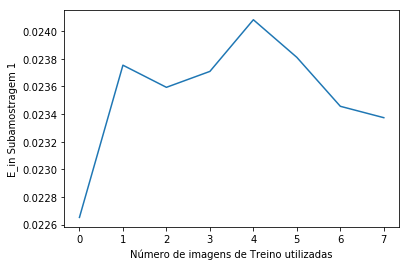

In [13]:
plt.plot(e_in1)
plt.xlabel('Número de imagens de Treino utilizadas')
plt.ylabel('E_in Subamostragem 1')
plt.show()

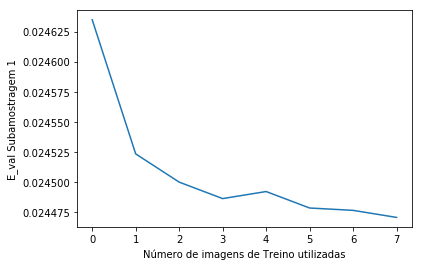

In [14]:
plt.plot(e_val1)
plt.xlabel('Número de imagens de Treino utilizadas')
plt.ylabel('E_val Subamostragem 1')
plt.show()

In [15]:
#subamostragem2 window1, window1c, window1b
e_in2 = []
e_val2 = []
results_sub2 = [results1, results1c, results1b]
windows_sub2 = [window1, window1c, window1b]
centers_sub2 = [center1a, center1b, center1c]
for i in range(8):
    results = [results_sub2[0][i], results_sub2[1][i], results_sub2[2][i]]
    e_in = 0.0
    e_val = 0.0
    for j in range(i+1):
        res_image = apply_learnmult(results, in_images1[j], windows_sub2, centers_sub2)
        e_in += (calculate_error(res_image, out_image1[j]))
    e_in2.append(e_in/(W*H*(i+1)))
    
    for j in range(8, 10):
        res_image = apply_learnmult(results, in_images1[j], windows_sub2, centers_sub2)
        e_val += calculate_error(res_image, out_image1[j])
    e_val2.append(e_val/(H*W*2))
        

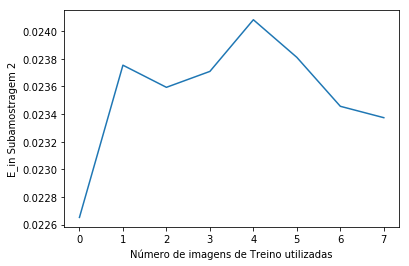

In [16]:
plt.plot(e_in2)
plt.xlabel('Número de imagens de Treino utilizadas')
plt.ylabel('E_in Subamostragem 2')
plt.show()

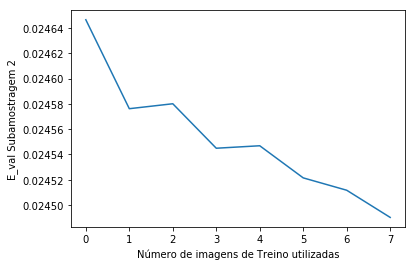

In [17]:
plt.plot(e_val2)
plt.xlabel('Número de imagens de Treino utilizadas')
plt.ylabel('E_val Subamostragem 2')
plt.show()

In [18]:
#subamsotragem3 window1, window1d, window1e, window1b
e_in3 = []
e_val3 = []
results_sub3 = [results1, results1d, results1e, results1b]
windows_sub3 = [window1, window1d, window1e, window1b]
centers_sub3 = [center1a,  center1a, center1b, center1c]
for i in range(8):
    results = [results_sub3[0][i], results_sub3[1][i], results_sub3[2][i], results_sub3[3][i]]
    e_in = 0.0
    e_val = 0.0
    for j in range(i+1):
        res_image = apply_learnmult(results, in_images1[j], windows_sub3, centers_sub3)
        e_in += calculate_error(res_image, out_image1[j])
    e_in3.append(e_in/(H*W*(i+1)))
    
    for j in range(8, 10):
        res_image = apply_learnmult(results, in_images1[j], windows_sub3, centers_sub3)
        e_val += calculate_error(res_image, out_image1[j])
    e_val3.append(e_val/(H*W*2))


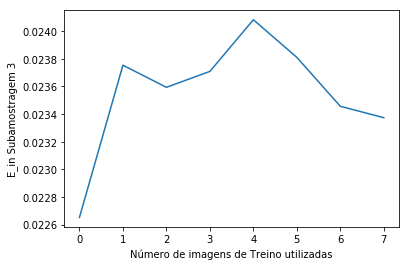

In [19]:
plt.plot(e_in3)
plt.xlabel('Número de imagens de Treino utilizadas')
plt.ylabel('E_in Subamostragem 3')
plt.show()

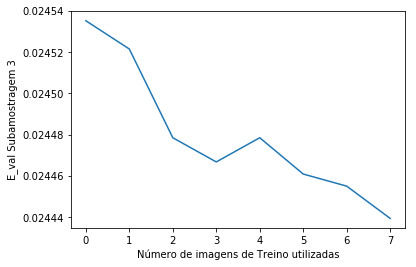

In [20]:
plt.plot(e_val3)
plt.xlabel('Número de imagens de Treino utilizadas')
plt.ylabel('E_val Subamostragem 3')
plt.show()

In [25]:
e_vals = [e_val1[7], e_val2[7], e_val3[7]]
print(np.argmin(e_vals))
min_eval = np.argmin(e_vals)

2


In [27]:
e_in = 0.0
if min_eval == 0:
    resulta = learn_geral(in_images1, out_image1, window1, center1a)
    resultb = learn_geral(in_images1, out_image1, window1a, center1a)
    resultc = learn_geral(in_images1, out_image1, window1b, center1c)
    results = [resulta, resultb. resultc]
    windows = [window1, window1a, window1b]
    centers = [center1a, center1a, center1c]
    for image in in_images1:
        res_image = apply_learnmult(results, image, windows, centers)
        e_in += calculate_error(res_image, out_image1[0])
    e_in = (e_in/(H*W*10))

elif min_eval == 1:
    resulta = learn_geral(in_images1, out_image1, window1, center1a)
    resultb = learn_geral(in_images1, out_image1, window1c, center1b)
    resultc = learn_geral(in_images1, out_image1, window1b, center1c)
    results = [resulta, resultc, resultb]
    windows = [window1, window1c, window1b]
    centers = [center1a, center1b, center1c]
    for image in in_images1:
        res_image = apply_learnmult(results, image, windows, centers)
        e_in += calculate_error(res_image, out_image1[0])
    e_in = (e_in/(H*W*10))
        
else:
    resulta = learn_geral(in_images1, out_image1, window1, center1a)
    resultb = learn_geral(in_images1, out_image1, window1d, center1a)
    resultc = learn_geral(in_images1, out_image1, window1e, center1b)
    resultd = learn_geral(in_images1, out_image1, window1b, center1c)
    results = [resulta, resultb, resultc, resultd]
    windows = [window1, window1d, window1e, window1b]
    centers = [center1a, center1a, center1b, center1c]
    for image in in_images1:
        res_image = apply_learnmult(results, image, windows, centers)
        e_in += calculate_error(res_image, out_image1[0])
    e_in = (e_in/(H*W*10))
        
print("Subamostragem escolhida foi", min_eval+1, "com erro de entrada e_in:", e_in)

Subamostragem escolhida foi 3 com erro de entrada e_in: 0.023566015625


Q2. Considere novamente o problema de filtrar ruído. Utilizando as imagens da pasta imgs/q2/, explore diferentes funções booleanas para filtrar ruído. A operação **abertura** é definida como uma **erosão** seguida por uma **dilatação**, isto é $\delta_{B2}\epsilon_{B1}$, onde $B1$ e $B2$ são os elementos estruturantes. De modo semelhante, a função **fechamento** é definida por uma **dilatação** seguida por uma **erosão** ($\epsilon_{B2}\delta_{B1}$). Baseado nas funções *erosion* e *dilation* definidas em mac0460_5832/utils.py, teste os seguintes espaços de hipóteses:

1. Abertura;
2. Fechamento;
3. Abertura seguida de fechamento;

Para cada espaço de hipóteses, defina diferentes funções variando $B1$ e $B2$ (ou seja, crie as funções de maneira análoga à seguinte definição para um conjunto de aberturas: $\mathcal{F} = \{\psi_{B1B2}: \psi =  \delta_{B2}\epsilon_{B1}, B1, B2 \subseteq W_{3x3} \}$, onde $W_{3x3}$ é a janela 3x3). Mostre a função que tem menor erro e verifique o seu desempenho nos dados de teste.

Obs: existe no utils.py funções para abertura e fechamento. No entanto, essas funções utilizam o mesmo elemento estruturante para a erosão e dilatação, não permitindo o uso de diferentes elementos estruturantes. 

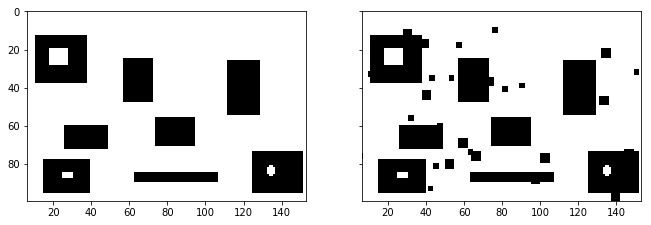

In [4]:
# Exemplo 
draw_img_pair(read_img('imgs/q2/dest.png'), read_img('imgs/q2/src0.png'), figsz=(11, 3.5))

In [5]:
#leitura das imagens
in_images2 = []
out_image2 = read_img("imgs/q2/dest.png")
test_images2 = []
for i in range(5):
    in_images2.append(read_img("imgs/q2/src{}.png".format(i)))
for i in range(2):
    test_images2.append(read_img("imgs/q2/test{}.png".format(i)))

In [6]:
def my_opening(image, b1, b2):
    new_image = dilation(erosion(image, b1), b2)
    return new_image

def my_closing(image, b1, b2):
    new_image = erosion(dilation(image, b1), b2)
    return new_image

In [7]:
min_errO = float("inf")
min_errC = float("inf")
min_errOC = float("inf")
chosenO = []
chosenC = []
chosenOC = []

In [8]:
for b1 in itertools.product([0, 1], repeat=9):
    b1 = np.reshape(b1, (3, 3)).astype('bool')
    for b2 in itertools.product([0, 1], repeat=9):
        b2 = np.reshape(b2, (3, 3)).astype('bool')
        errorO = 0.0
        errorC = 0.0
        errorOC = 0.0
        for k in range(len(in_images2)):
            res_imageo = my_opening(in_images2[k], b1, b2)
            res_imagec = my_closing(in_images2[k], b1, b2)
            res_imageoc = my_closing(res_imageo, b2, b1)
            errorO += calculate_error(res_imageo, out_image2)
            errorC += calculate_error(res_imagec, out_image2)
            errorOC += calculate_error(res_imageoc, out_image2)
        if (errorO < min_errO): 
            min_errO = errorO
            chosen_O = (b1, b2)
        if (errorC < min_errC):
            min_errC = errorC
            chosen_C = (b1, b2)
        if(errorOC < min_errOC):
            min_errOC = errorOC
            chosen_OC = (b1, b2)


OPENING


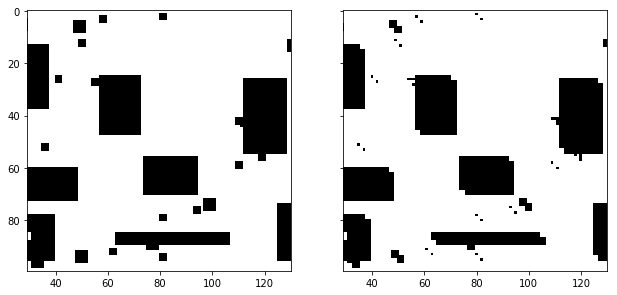

CLOSING


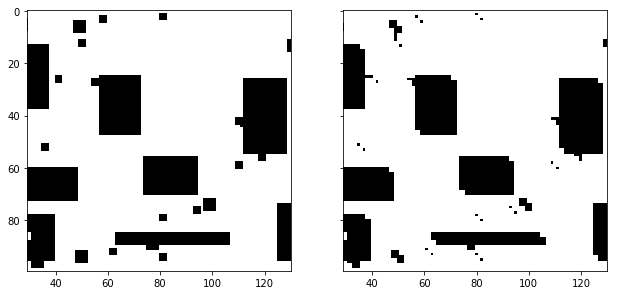

OPENING SEGUIDO DE CLOSING


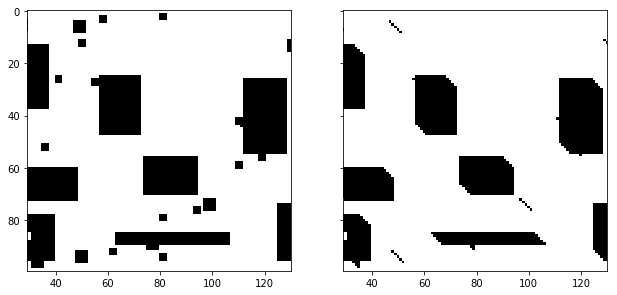

OPENING


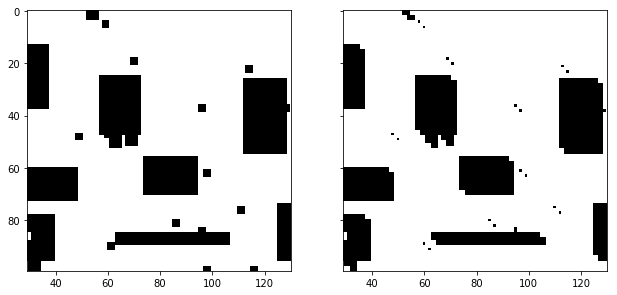

CLOSING


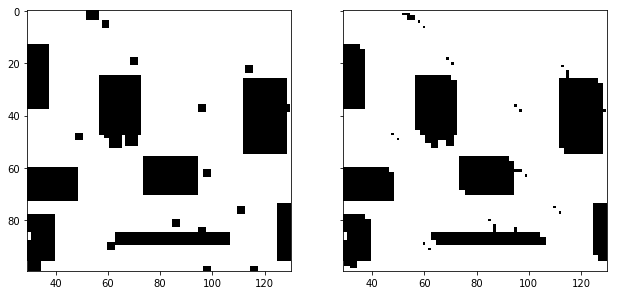

OPENING SEGUIDO DE CLOSING


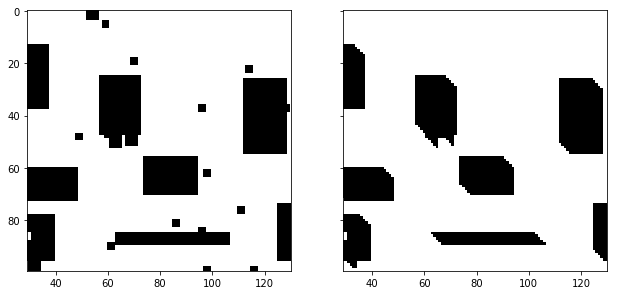

In [9]:
for i in range(len(test_images2)):
    print("OPENING")
    draw_img_pair(test_images2[i], my_opening(test_images2[i], chosen_O[0], chosen_O[1]))
    print("CLOSING")
    draw_img_pair(test_images2[i], my_closing(test_images2[i], chosen_C[0], chosen_C[1]))
    print("OPENING SEGUIDO DE CLOSING")
    draw_img_pair(test_images2[i], my_closing(my_opening(test_images2[i], chosen_OC[0], chosen_OC[1]),
                                              chosen_OC[1], chosen_OC[0]))

In [10]:
print(min_errO, min_errC, min_errOC)
print(chosen_O[0], chosen_O[1])
print(chosen_C[0], chosen_C[1])
print(chosen_OC[0] , chosen_OC[1])

1386.0 1402.0 1104.0
[[ True False  True]
 [False False  True]
 [ True  True  True]] [[ True False False]
 [False False False]
 [False False  True]]
[[ True False False]
 [False False False]
 [False False  True]] [[ True  True  True]
 [ True False  True]
 [ True  True  True]]
[[ True  True  True]
 [ True False  True]
 [ True  True  True]] [[ True False False]
 [False  True False]
 [False False  True]]
